Based on these posts: 
* https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
* https://github.com/keisukeirie/Amazon_review_helpfulness_prediction
* https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
* https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [1]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
a

In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [8]:
!head ./data/amazon90000.tsv

marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	12190288	R3FU16928EP5TC	B00AYB1482	668895143	Enlightened: Season 1	Digital_Video_Download	5	0	0	N	Y	I loved it and I wish there was a season 3	I loved it and I wish there was a season 3... I watched season 2 and loved that as well!	2015-08-31
US	30549954	R1IZHHS1MH3AQ4	B00KQD28OM	246219280	Vicious	Digital_Video_Download	5	0	0	N	Y	As always it seems that the best shows come from England	As always it seems that the best shows come from England. best of the best without words, i cant wait to watch season two.	2015-08-31
US	52895410	R52R85WC6TIAH	B01489L5LQ	534732318	After Words	Digital_Video_Download	4	17	18	N	Y	Charming movie	This movie isn't perfect, but it gets a lot of things right. Yes, the librarian character played by Marcia Gay Harden is stereotypical and played a bit heavy-handed. But the

In [9]:
df = pd.read_csv('./data/amazon90000.tsv', delimiter='\t')
df.shape

(88395, 15)

In [10]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop any NaNs

In [11]:
df.shape

(88395, 15)

In [12]:
df.isna().values.any()

True

In [13]:
df_cleaned_and_filtered = df.dropna()
df_cleaned_and_filtered = df_cleaned_and_filtered.reset_index()
df_cleaned_and_filtered.shape

(88391, 16)

In [14]:
df_cleaned_and_filtered = df_cleaned_and_filtered.query('helpful_votes > 0')
df_cleaned_and_filtered.shape

(9301, 16)

In [15]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31


In [16]:
df_cleaned_and_filtered['pct_helpful_votes'] = df_cleaned_and_filtered['helpful_votes'] / df_cleaned_and_filtered['total_votes']
df_cleaned_and_filtered.shape

(9301, 17)

In [17]:
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000


In [18]:
df_cleaned_and_filtered['is_helpful'] = df_cleaned_and_filtered['pct_helpful_votes'] > 0.75
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True


In [19]:
df_cleaned_and_filtered['is_positive_sentiment'] = (df_cleaned_and_filtered['star_rating'] >= 4).astype(int)
df_cleaned_and_filtered.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,pct_helpful_votes,is_helpful,is_positive_sentiment
2,2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,0.944444,True,1
5,5,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31,0.833333,True,1
6,6,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31,1.000000,True,1
18,18,US,47856888,R1ZHHD1GTHGMNK,B005U9RM0W,728197314,Grimm Season 1,Digital_Video_Download,4,1,1,N,Y,If you're a sucker for supernatural series the...,If you're a sucker for supernatural series the...,2015-08-31,1.000000,True,1
55,55,US,52684121,R203639GCLF7XV,B00MYLVPFM,773772186,Amazing Race 8,Digital_Video_Download,1,5,5,N,Y,Like many other viewers I felt the Family edit...,Like many other viewers I felt the Family edit...,2015-08-31,1.000000,True,0


In [20]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


## Balance the dataset

In [21]:
from sklearn.utils import resample

is_negative_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_cleaned_and_filtered.query('is_positive_sentiment == 1')

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False, # sample without replacement
                                      n_samples = len(is_negative_sentiment_df), # match minority n
                                      random_state = 27) # reproducible results

df_cleaned_and_filtered = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])


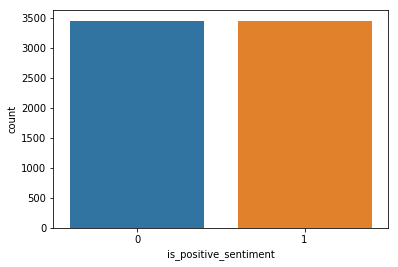

In [22]:
sns.countplot(x='is_positive_sentiment', data=df_cleaned_and_filtered)


In [23]:
from sklearn.model_selection import train_test_split

#df_train, df_holdout = train_test_split(df_cleaned_and_filtered, test_size=0.10)
#df_validation, df_test = train_test_split(df_holdout, test_size=0.5)

X = df_cleaned_and_filtered[['review_body']]
y = df_cleaned_and_filtered['is_positive_sentiment']

print('X.shape:  {}'.format(X.shape))
print('y.shape:  {}'.format(y.shape))

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=0)

print('X.shape={}'.format(X.shape))
print('y.shape={}'.format(y.shape))

print('X_train.shape={}'.format(X_train.shape))
print('y_train.shape={}'.format(y_train.shape))

print('X_validation.shape={}'.format(X_validation.shape))
print('y_validation.shape={}'.format(y_validation.shape))

print('X_test.shape={}'.format(X_test.shape))
print('y_test.shape={}'.format(y_test.shape))

X.shape:  (6894, 1)
y.shape:  (6894,)
X.shape=(6894, 1)
y.shape=(6894,)
X_train.shape=(6204, 1)
y_train.shape=(6204,)
X_validation.shape=(345, 1)
y_validation.shape=(345,)
X_test.shape=(345, 1)
y_test.shape=(345,)


In [25]:
# TODO:  Remove this in favor of explicitly merging these wherever they are needed
X_train.reset_index()
y_train.reset_index()

df_train = X_train.merge(y_train)
#df_validation = X_validation.merge(y_validation)

#df_train.to_csv('./data/train.csv', index=False, header=True)
#df_validation.to_csv('./data/validation.csv', index=False, header=True)

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [31]:
prefix = 'sagemaker/xgboost/data'

train_data_uri = sess.upload_data(path="./data/train.csv", key_prefix=prefix + "/training")
validation_data_uri = sess.upload_data(path="./data/validation.csv", key_prefix=prefix + "/validation")

print(train_data_uri)
print(validation_data_uri)

#s3_input_train_data = sagemaker.s3_input(s3_data=train_data_uri, content_type='text/csv')
#s3_input_validation_data = sagemaker.s3_input(s3_data=validation_data_uri, content_type='text/csv')


s3://sagemaker-us-east-1-835319576252/sagemaker/xgboost/data/training/train.csv
s3://sagemaker-us-east-1-835319576252/sagemaker/xgboost/data/validation/validation.csv


# AutoML

Typical dataset split:  `train` => `validation` => `test`

However, we only specify `train` and `test` (not `validation`) for AutoML.

AutoML will use all of the `train` data - splitting into `train` and `validation` on its own.  

We hold out `test` to test the final model after AutoML generates the best model candidates.

In [36]:
#df_train_automl = X_train.merge(y_train, left_index=True, right_index=True)[['is_positive_sentiment', 'review_body']]
#df_validation = X_validation.merge(y_validation)

df_train_automl = df_train[['is_positive_sentiment', 'review_body']]
df_train_automl.shape


(6204, 2)

In [22]:
df_train_automl.head(5)

,is_positive_sentiment,review_body
35762,0,You don't want to know what I'd have to say.
74484,1,Part of a triology which spans a decade: falli...
42116,0,A couple full frontals and a few topless women...
40718,0,just an small piece of the show..
33023,1,"This is a truly beautiful movie, sensual and i..."


In [23]:
# TODO:  Change file name to indicate automl
# TODO:  Name `-train.csv` to distriguish from `-test.csv` next
df_train_automl.to_csv(path_or_buf='./data/amazon-digital-video-download-cleaned-and-filtered.csv', index=False)

In [24]:
df_test_automl = df_test[['is_positive_sentiment', 'review_body']]
df_test_automl.shape


NameError: name 'df_test' is not defined

In [25]:
df_test_automl.head(5)

NameError: name 'df_test_automl' is not defined

In [26]:
# TODO:  Change filename to indicate automl
df_test_automl.to_csv(path_or_buf='./data/amazon-digital-video-download-cleaned-and-filtered-test.csv', index=False)

NameError: name 'df_test_automl' is not defined

In [27]:
# TODO:  Unify these locations
prefix = 'xgboost-reviews/autopilot'

# TODO:  Change to `-train.csv` and remove the old files from S3 to avoid confusion
sess.upload_data(path='./data/amazon-digital-video-download-cleaned-and-filtered.csv', bucket=bucket, key_prefix=prefix + '/input')
sess.upload_data(path='./data/amazon-digital-video-download-cleaned-and-filtered-test.csv', bucket=bucket, key_prefix=prefix + '/input')

FileNotFoundError: [Errno 2] No such file or directory: './data/amazon-digital-video-download-cleaned-and-filtered-test.csv'

In [ ]:
!aws s3 ls $bucket/$prefix/input/

# Built-In

### Create X (features) and y (labels)

In [ ]:
X = df_cleaned_and_filtered[['review_body']]
y = df_cleaned_and_filtered['is_positive_sentiment']

print('X.shape:  {}'.format(X.shape))
print('y.shape:  {}'.format(y.shape))

# TODO:  Split again to separate `validation` from `test`

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.1, random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(X_holdout, y_holdout, test_size=0.5, random_state=0)

print('X.shape={}'.format(X.shape))
print('y.shape={}'.format(y.shape))

print('X_train.shape={}'.format(X_train.shape))
print('y_train.shape={}'.format(y_train.shape))

print('X_validation.shape={}'.format(X_validation.shape))
print('y_validation.shape={}'.format(y_validation.shape))

print('X_test.shape={}'.format(X_test.shape))
print('y_test.shape={}'.format(y_test.shape))


In [ ]:
X_train.head(5)

In [ ]:
y_train.head(5)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]

In [ ]:
import nltk
import re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier

feature_union = FeatureUnion([
        ('body', Pipeline([
            ('body_text_selector', TextSelector('review_body')),
            ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, stop_words="english",
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ]))
])

X_train_transformed = feature_union.fit_transform(X_train)
X_train_transformed.shape

In [ ]:
# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_train_new_pd = pd.DataFrame(X_train_transformed)
X_train_new_pd.insert(0, 'is_positive_sentiment', y_train)
X_train_new_pd = X_train_new_pd.fillna(0)

#cols = list(train_df)
#cols.insert(0, cols.pop(cols.index('OUTPUT_LABEL')))
#train_df = train_df.loc[:, cols]

X_train_new_pd.head(5)


# TODO:  Rename this to _builtin.csv or _tfidf.csv

In [ ]:
X_train_new_pd.to_csv('./data/train_transformed.csv', index=False, header=False)

In [ ]:
X_test_transformed = feature_union.fit_transform(X_test)
X_test_transformed.shape

In [ ]:
# For CSV training, the XGBoost built-in algorithm assumes that the target variable is in the first column and that the CSV does not have a header record.

X_test_new_pd = pd.DataFrame(X_test_transformed)
X_test_new_pd.insert(0, 'is_positive_sentiment', y_test)
X_test_new_pd = X_test_new_pd.fillna(0)

X_test_new_pd.head(5)


# TODO:  Rename this to _builtin.csv or _tfidf.csv

In [ ]:
X_test_new_pd.to_csv('./data/validation_transformed.csv', index=False, header=False)